In [1]:
%matplotlib inline
import matplotlib.style as style

import matplotlib.pyplot as plt
import numpy as np
import time

import scqubits as scq
import qutip as qt

style.use('default')
plt.rcParams['figure.figsize'] = [6, 4]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
scq.settings.PROGRESSBAR_DISABLED = True

In [2]:
hbar = 1
h = hbar*2*np.pi
qe = 1

# Unit conversions
MHz = 10.0**(-3)
GHz = 1.0
kHz = 10.0**(-6)
us = 10.0**3
ns = 1.0

In [3]:
transmon1_consts = dict(
    EC = 0.25 * GHz,
    EJ = 21.0 * GHz,
)

transmon2_consts = dict(
    EC = 0.3 * GHz,
    EJ = 20.0 * GHz,
)

transmon3_consts = dict(
    EC = 0.35 * GHz,
    EJ = 22.0 * GHz,
)

q1_isCavity = False
q2_isCavity = False
q3_isCavity = False


transmon1 = scq.Transmon(
    **transmon1_consts, ng=0, ncut = 110, truncated_dim = 10
)

transmon2 = scq.Transmon(
    **transmon2_consts, ng=0, ncut = 110, truncated_dim = 10
)

transmon3 = scq.Transmon(
    **transmon3_consts, ng=0, ncut = 110, truncated_dim = 10
)

In [4]:
evals_count = 5
cutoff = evals_count

evals1, evecs1 = transmon1.eigensys(evals_count=evals_count)
evals1 = evals1 - evals1[0] 

evals2, evecs2 = transmon2.eigensys(evals_count=evals_count)
evals2 = evals2 - evals2[0]

evals3, evecs3 = transmon3.eigensys(evals_count=evals_count)
evals3 = evals3 - evals3[0]

alpha1 = alpha2 = alpha3 = 0
if not q1_isCavity: alpha1 = evals1[2]-2*evals1[1]
if not q2_isCavity: alpha2 = evals2[2]-2*evals2[1]
if not q3_isCavity: alpha3 = evals3[2]-2*evals3[1]

print(evals1[1], evals2[1], evals3[1], alpha1, alpha2, alpha3)

6.219955176682575 6.613448853505485 7.480762973458873 -0.27656660001468936 -0.3368931055765696 -0.3947192737967242


In [5]:
# Map bare states of each transmon to dressed states in combined system
def find_level(H, ket_orig_basis, esys=None):
    if esys == None:
        esys = H.eigenstates()
    evals, evecs = esys
    best_overlap = 0
    best_state = -1
    for n, evec in enumerate(evecs):
        assert evec.shape == ket_orig_basis.shape
        overlap = np.abs(ket_orig_basis.overlap(evec))
        if overlap > best_overlap:
            best_overlap = overlap
            best_state = n
    # print(best_state)
    return best_state, evecs[best_state]

def make_tensor_prod_level(levels, cutoff=cutoff):
    prod = []
    lvl = dict(g=0, e=1, f=2, h=3,)
    # print(levels)
    for level in levels:
        if isinstance(level, str): level = lvl[level]
        prod.append(qt.basis(cutoff, level))
    return qt.tensor(*prod)

def state(H, levels, cutoff=cutoff, esys=None):
    return find_level(H, make_tensor_prod_level(levels, cutoff=cutoff), esys=esys)[1]

In [6]:
# Amplitude = 1 gaussian
def gaussian(x, sigma):
#     return 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(x-x0)**2/2/sigma**2)
    return np.exp(-x**2/2/sigma**2)

In [7]:
times = np.linspace(0, 500, 150)

t_rise = 1 # ns

# Note: pi pulses need to be calibrated with both of the couplings turned on
# t_pulse_12 = 100000
# t_pulse_12 = 0
# t_pulse_23 = 100000
# eps_12 = 0
# eps_23 = 0

# SEQUENTIAL SIN^2 RISE PULSES
# g12 = 0.2
# g23 = 0.45
# eps_12 = 0.05 # GHz # drive amplitude
# eps_23 = 0.15 # GHz # drive amplitude
# t_pulse_12 = 23.2694
# t_pulse_23 = 92.7039
# t_start_12 = 0
# t_start_23 = t_pulse_12

# SIMULTANEOUS SIN^2 RISE PULSES
# g12 = 0.2
# g23 = 0.45
# eps_12 = 0.05 # GHz # drive amplitude
# eps_23 = 0.15 # GHz # drive amplitude
# t_pulse_12 = 23.2694
# t_pulse_23 = 101.8349
# t_start_12 = 0
# t_start_23 = 0

# print('Total time:', max(t_start_12 + t_pulse_12, t_start_23 + t_pulse_23))

# SEQ GAUSSIAN PULSES (EQUAL WIDTHS)
# g12 = 0.1
# g23 = 0.45
# eps_12 = 0.015 # GHz # drive amplitude
# eps_23 = 0.18 # GHz # drive amplitude
# t_pulse_12 = 30
# t_pulse_23 = 30
# t_start_12 = 10 
# t_start_23 = t_start_12 + 6*t_pulse_12

# SIMULTANEOUS GAUSSIAN PULSES (EQUAL WIDTHS) (not quite but close)
# g12 = 0.1
# g23 = 0.45
# eps_12 = 0.011 # GHz # drive amplitude
# # eps_12 = 0.0 # GHz # drive amplitude
# eps_23 = 0.14 # GHz # drive amplitude
# t_pulse_12 = 60
# t_pulse_23 = 60
# t_start_12 = 10 
# t_start_23 = t_start_12

# STIRAP GAUSSIAN PULSES
g12 = 0.1
g23 = 0.45
eps_12 = 0.011 # GHz # drive amplitude
eps_23 = 0.18 # GHz # drive amplitude
t_pulse_12 = 30
t_pulse_23 = 30
t_start_23 = 10
t_start_12 = t_start_23 + 1*t_pulse_23 

In [8]:
a = qt.tensor(qt.destroy(cutoff), qt.qeye(cutoff), qt.qeye(cutoff)) # source
b = qt.tensor(qt.qeye(cutoff), qt.destroy(cutoff), qt.qeye(cutoff)) # switch
c = qt.tensor(qt.qeye(cutoff), qt.qeye(cutoff), qt.destroy(cutoff)) # out1
H_source    = 2*np.pi*(evals1[1]*a.dag()*a + 1/2*alpha1*a.dag()*a*(a.dag()*a - 1))
H_switch    = 2*np.pi*(evals2[1]*b.dag()*b + 1/2*alpha2*b.dag()*b*(b.dag()*b - 1))
H_out1      = 2*np.pi*(evals3[1]*c.dag()*c + 1/2*alpha3*c.dag()*c*(c.dag()*c - 1))
H_int_12 = 2*np.pi*g12 * (a * b.dag() + a.dag() * b)
H_int_23 = 2*np.pi*g23 * (b * c.dag() + b.dag() * c)

H = H_source + H_switch + H_int_12 + H_out1 + H_int_23


In [9]:
# SEQUENTIAL + SIMULTANEOUS SWAP WITH SIN^2 RAMP

# drive at wd = w1 - w2 
# wd_12 = (qt.expect(H, state(H, 'geg')) - qt.expect(H, state(H, 'fgg')))
wd_12 = (qt.expect(H, state(H, 'egg')) - qt.expect(H, state(H, 'gfg')))
print('wd_12/2pi', wd_12/2/np.pi)

wd_23 = (qt.expect(H, state(H, 'gfg')) - qt.expect(H, state(H, 'gge')))
# wd_23 = (qt.expect(H, state(H, 'egg')) - qt.expect(H, state(H, 'gfg')))
print('wd_23/2pi', wd_23/2/np.pi)

# need a^\dag + a for fg <-> ge and b^\dag + b for gf <-> eg
# H_drive_12 = 2*np.pi* 1/2 * (a.dag()+a)
H_drive_12 = 2*np.pi* 1/2 * (b.dag()+b)
def H_drive_envelope_12(t):
    t -= t_start_12
    if 0 <= t < t_rise: return eps_12 * np.sin(np.pi*t/2/t_rise)**2
    elif t_rise <= t < t_pulse_12 - t_rise: return eps_12
    elif t_pulse_12 - t_rise <= t < t_pulse_12: return eps_12 * np.sin(np.pi*(t_pulse_12-t)/2/t_rise)**2
    return 0
def H_drive_func_12(t, args):
    return H_drive_envelope_12(t) * np.sin(wd_12 * t)

# H_drive_23 = 2*np.pi* 1/2 * (a.dag()+a)
H_drive_23 = 2*np.pi* 1/2 * (b.dag()+b)
def H_drive_envelope_23(t):
    t -= t_start_23
    if 0 <= t < t_rise: return eps_23 * np.sin(np.pi*t/2/t_rise)**2
    elif t_rise <= t < t_pulse_23 - t_rise: return eps_23
    elif t_pulse_23 - t_rise <= t < t_pulse_23: return eps_23 * np.sin(np.pi*(t_pulse_23-t)/2/t_rise)**2
    return 0
def H_drive_func_23(t, args):
#     if t < t_pulse_23: amp = eps_23
#     else: amp = 0
    return H_drive_envelope_23(t)* np.sin(wd_23 * t)

H_solver = [H, [H_drive_12, H_drive_func_12], [H_drive_23, H_drive_func_23]]

wd_12/2pi -6.309174566525761
wd_23/2pi 4.819510676217441


In [10]:
# GAUSSIAN STIRAP PULSE

# drive at wd = w1 - w2 
# wd_12 = (qt.expect(H, state(H, 'geg')) - qt.expect(H, state(H, 'fgg')))
wd_12 = (qt.expect(H, state(H, 'egg')) - qt.expect(H, state(H, 'gfg')))
print('wd_12/2pi', wd_12/2/np.pi)

wd_23 = (qt.expect(H, state(H, 'gfg')) - qt.expect(H, state(H, 'gge')))
# wd_23 = (qt.expect(H, state(H, 'egg')) - qt.expect(H, state(H, 'gfg')))
print('wd_23/2pi', wd_23/2/np.pi)

# need a^\dag + a for fg <-> ge and b^\dag + b for gf <-> eg
# H_drive_12 = 2*np.pi* 1/2 * (a.dag()+a)
H_drive_12 = (b.dag()+b)
def H_drive_envelope_12(t):
    t_max = t_start_12 + 3*t_pulse_12
    return gaussian(t - t_max, t_pulse_12)
def H_drive_func_12(t, args):
    return 2*np.pi* 1/2 * eps_12 * H_drive_envelope_12(t) * np.sin(wd_12 * t)

# H_drive_23 = 2*np.pi* 1/2 * (a.dag()+a)
H_drive_23 = (b.dag()+b)
def H_drive_envelope_23(t):
    t_max = t_start_23 + 3*t_pulse_23
    return gaussian(t - t_max, t_pulse_23)
def H_drive_func_23(t, args):
    return 2*np.pi* 1/2 * eps_23 * H_drive_envelope_23(t)* np.sin(wd_23 * t)

H_solver = [H, [H_drive_12, H_drive_func_12], [H_drive_23, H_drive_func_23]]

wd_12/2pi -6.309174566525761
wd_23/2pi 4.819510676217441


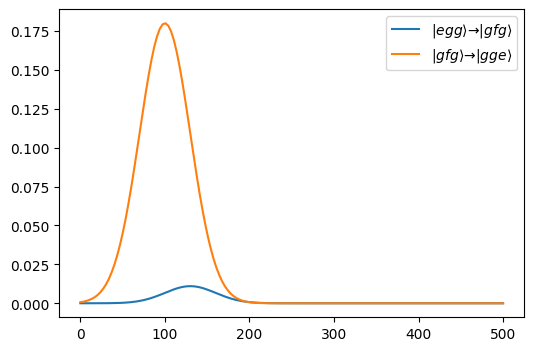

In [11]:
plt.plot(times, [eps_12 * H_drive_envelope_12(t) for t in times], label=r'$|egg\rangle \to |gfg\rangle$')
plt.plot(times, [eps_23 * H_drive_envelope_23(t) for t in times], label=r'$|gfg\rangle \to |gge\rangle$')
plt.legend()
plt.show()

In [12]:
psi0_name = 'egg'
# psi0_name = 'gfg'

start_time = time.time()
result = qt.mesolve(H_solver, state(H, psi0_name), times, options=qt.Options(nsteps=10000)).states
print('Time:', time.time()-start_time)

Time: 40.326953172683716


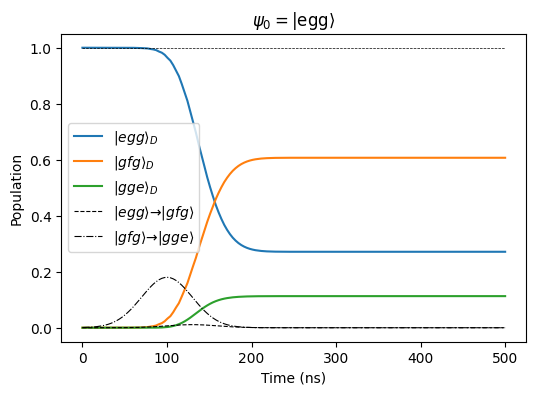

In [13]:
esys = H.eigenstates()
plot_states = dict(
    egg=state(H, 'egg', esys=esys),
    gfg=state(H, 'gfg', esys=esys),
    gge=state(H, 'gge', esys=esys),
    ggg=state(H, 'ggg', esys=esys),
    fgg=state(H, 'fgg', esys=esys),
    geg=state(H, 'geg', esys=esys),
    ggf=state(H, 'ggf', esys=esys),
)
plt.plot(times, [np.abs(plot_states['egg'].overlap(result[t]))**2 for t in range(len(times))], label=r'$|egg\rangle_D$')
plt.plot(times, [np.abs(plot_states['gfg'].overlap(result[t]))**2 for t in range(len(times))], label=r'$|gfg\rangle_D$')
plt.plot(times, [np.abs(plot_states['gge'].overlap(result[t]))**2 for t in range(len(times))], label=r'$|gge\rangle_D$')
# plt.plot(times, [np.abs(plot_states['geg'].overlap(result[t]))**2 for t in range(len(times))], label=r'$|geg\rangle_D$')
# plt.plot(times, [np.abs(plot_states['fgg'].overlap(result[t]))**2 for t in range(len(times))], label=r'$|fgg\rangle_D$')
# plt.plot(times, [np.abs(plot_states['ggf'].overlap(result[t]))**2 for t in range(len(times))], label=r'$|ggf\rangle_D$')
plt.plot(times, [eps_12 * H_drive_envelope_12(t) for t in times], 'k--', linewidth=0.8, label=r'$|egg\rangle \to |gfg\rangle$')
plt.plot(times, [eps_23 * H_drive_envelope_23(t) for t in times], 'k-.', linewidth=0.8, label=r'$|gfg\rangle \to |gge\rangle$')
plt.plot(times, [1]*len(times), 'k--', linewidth=0.5)
plt.legend()
# plt.ylim(0,1)
plt.xlabel('Time (ns)')
plt.ylabel('Population')
plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
plt.show()

In [14]:
# Get pi pulse length (could do a fit but this is easier)
popln = np.array([np.abs(plot_states['gfg'].overlap(result[t]))**2 for t in range(len(times))])
search_ti = 50
search_tf = 125
pi = np.argmin(np.abs(times-search_ti)) + \
    np.argmin(popln[np.argmin(np.abs(times-search_ti)):np.argmin(np.abs(times-search_tf))])
print(times[pi])

50.33557046979866
